# Investigating the effect of the pandemic on atmospheric $\text{CO}_{2}$ levels

I want to look at the recent atmospheric data from the Mauna Loa observatory and the Global Monitoring Division of NOAA/Earth System Research Laboratory (ESRL), and evaluate to what extent - if any - has the pandemic affected the atmospheric $\text{CO}_{2}$ levels. The pandemic brought about massive global lifestyle changes, with remote workers staying at home in mandated lockdowns in particular. The expectation is that with more people working from home, there is less commuting needed for work, and therefore less contributions to pollution from commuting workers. In the data, this effect should reduce the growth/gradient of the trend of atmospheric $\text{CO}_{2}$ by some degree.

The data from the Mauna Loa observatory is accrued at an altitude of 3400 metres, whereas the ESRL data is from marine surface sites and is measured closer to sea level. This means that there is a difference in the dataset values for atmospheric $\text{CO}_{2}$ levels. NOTE: for both datasets, the last year of data is preliminary, so the results from this analysis may be subject to change. The Mauna Loa dataset was found at https://gml.noaa.gov/ccgg/trends/data.html and the ESRL dataset was found at https://gml.noaa.gov/ccgg/trends/gl_data.html. Both datasets are continuously updated over time. The last update for the datasets used in this notebook is 2022-06-06.

This workbook will perform a basic SARIMA analysis of both datasets prior to the COVID outbreak. The SARIMA model will be evaluated on its ability to predict pre-pandemic data, using the root mean squared error metric. If suitable, this SARIMA model will be used to forecast into the pandemic, and said forecast will be compared to the measured data.

## Background
To start, we can ask the preliminary question - if there is a difference due to the pandemic, what do we expect it to look like qualitatively? The owners of this data set have provided some elementary knowledge as to what we expect from the pandemic at https://gml.noaa.gov/ccgg/covid2.html. There, they answer a different question that is related to ours, but help outline a key feature of the data that we will look for. I will reiterate some of what they have posted and link it to our data.

Suppose a significant majority of the now remote workers were causing the up-trend in atmospheric $\text{CO}_{2}$ by commuting to work. When they went remote, the gradient of the trend would then be close to zero. However, without any other man-made $\text{CO}_{2}$ mitigation or removal methods, the $\text{CO}_{2}$ levels would remain at a constant level and not fall to zero. This is because atmospheric $\text{CO}_{2}$ is essentially recycled. 

$\text{CO}_{2}$ does not photo-disintegrate like other greenhouse gases (photo-disintegration is where chemicals change forms/break down due to the interaction of light - sunlight in this case). Oceans can dissolve $\text{CO}_{2}$, but $\text{CO}_{2}$ can also leave the ocean too. Plants do convert $\text{CO}_{2}$ via photosynthesis, but this $\text{CO}_{2}$ removal is offset by living organisms breathing and by fires. Since plant life begets living organisms, the $\text{CO}_{2}$ levels tend to not decrease due to plants. Theoretically, if some new plants are introduced in an isolated man-made ecosystem - without any risk of introducing more living organisms or fires - then potentially they could decrease the $\text{CO}_{2}$ levels. Alternatively, if one cannot guarantee no new living organisms but can guarantee fireproofing, if the number of new living organisms sustained by plants saturates with number of plants grown, then additional plants past this saturation point may decrease the $\text{CO}_{2}$ levels. Outside of these hypothetical man-made scenarios, there is no natural mechanism in which $\text{CO}_{2}$ leaves the atmosphere permanently, besides the relatively small contributions from the chemical weathering and the formation of rocks. 

Some methods aim to capture the carbon (https://en.wikipedia.org/wiki/Carbon_capture_and_storage) before it enters the atmosphere and store it indefinitely, but this mainly applies to controlled processes by corporations and less to commuters. There are some more direct options of $\text{CO}_{2}$ removal from the atmosphere (https://en.wikipedia.org/wiki/Carbon_dioxide_removal), such as afforestation and reforestation, but careful measures need to be considered, such as not negatively impacting the biodiversity of the species already living in these targeted areas. To the best of my knowledge, there has not been any major/aggressive $\text{CO}_{2}$ removal strategies employed during the pandemic.

Due to the natural recycling of atmospheric $\text{CO}_{2}$ and the lack of significant $\text{CO}_{2}$ removal campaigns during the pandemic, the most extreme extent of our expectation here is that the measured trend flat-lines at the level just before the pandemic started, and the seasonal component remains the same. The seasonal component should remain the same since it is mainly due to plant's responses to seasonal variations in ecological factors (such as temperature, humidity and soil moisture), which largely has not been affected by the pandemic, and certainly has not been largely affected by changing commuter habits.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Grid search for optimal ARIMA parameters.
from pmdarima import auto_arima
# Seasonal ARIMA X.
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Seasonal decomposition.
from statsmodels.tsa.seasonal import seasonal_decompose

# Ignore harmless warnings.
import warnings
warnings.filterwarnings("ignore")

# Metrics for model evaluation.
from statsmodels.tools.eval_measures import rmse

## 1) Mauna Loa data

In [2]:
# Reading in the Mauna Loa dataset.
df = pd.read_csv("co2_mm_mlo.csv")
df.head()

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


In [3]:
# Dataframe has years and months as separate columns,
# so we can transform them into a datetime object and
# use it for the index. We will use the month start (MS)
# frequency type.
df['date'] = pd.to_datetime(arg = {'year':df['year'],'month':df['month'],'day':1})
print(df.head())
print('\n')
print(df.info())

   year  month  decimal date  average  deseasonalized  ndays  sdev   unc  \
0  1958      3     1958.2027   315.70          314.43     -1 -9.99 -0.99   
1  1958      4     1958.2877   317.45          315.16     -1 -9.99 -0.99   
2  1958      5     1958.3699   317.51          314.71     -1 -9.99 -0.99   
3  1958      6     1958.4548   317.24          315.14     -1 -9.99 -0.99   
4  1958      7     1958.5370   315.86          315.18     -1 -9.99 -0.99   

        date  
0 1958-03-01  
1 1958-04-01  
2 1958-05-01  
3 1958-06-01  
4 1958-07-01  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771 entries, 0 to 770
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year            771 non-null    int64         
 1   month           771 non-null    int64         
 2   decimal date    771 non-null    float64       
 3   average         771 non-null    float64       
 4   deseasonalized  771 non-null  

In [4]:
# Counting all the na values
# for the average monthly emissions column.
sum(df['average'].isna())
# If n_null = 0 we can proceed with the analysis.

0

In [5]:
# Now we set the index as the date column.
# MS stands for month start.
df.set_index(keys = ['date'], drop = True, inplace = True)
df.index.freq = 'MS'
df.index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01'],
              dtype='datetime64[ns]', name='date', length=771, freq='MS')

Text(0, 0.5, 'Average atmospheric CO2 (ppm)')

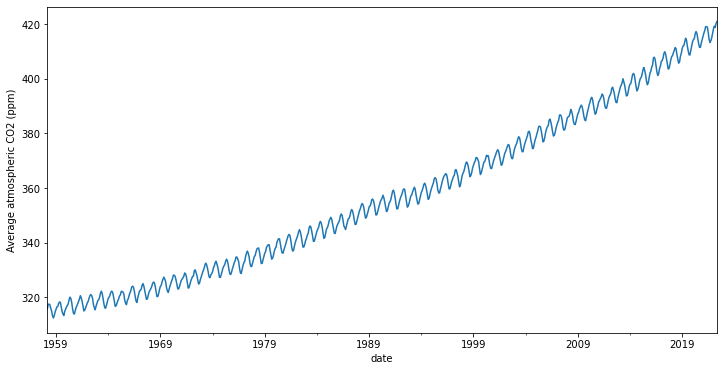

In [6]:
# Plotting the data shows seasonality and an upwards trend.
ax = df['average'].plot(figsize = (12,6))
ax.set_ylabel(ylabel = 'Average atmospheric CO2 (ppm)')

### SARIMAX grid search

In [7]:
# I am considering all dates prior to 2020
# as the pre-pandemic era, and dates post
# 2020 as the pandemic era. Today's date is
# 2022-06-09.
# Whilst the first detected case was in 2019,
# the WHO declared COVID-19 as a
# Public Health Emergency of International
# Concern on 2020-01-30, so starting at
# 2020 is a reasonable split.
pre_dates = df[df['year'] < 2020]
dates = df[df['year'] >= 2020]
print(pre_dates.info())
print('\n')
print(dates.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 742 entries, 1958-03-01 to 2019-12-01
Freq: MS
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            742 non-null    int64  
 1   month           742 non-null    int64  
 2   decimal date    742 non-null    float64
 3   average         742 non-null    float64
 4   deseasonalized  742 non-null    float64
 5   ndays           742 non-null    int64  
 6   sdev            742 non-null    float64
 7   unc             742 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 52.2 KB
None


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2020-01-01 to 2022-05-01
Freq: MS
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            29 non-null     int64  
 1   month           29 non-null     int64  
 2   decimal date    29 non-null     float64
 3  

In [8]:
# Using auto_arima grid search to find
# optimal fitting parameters for the
# train data.
auto_arima_df = auto_arima(y = pre_dates['average'],
                           seasonal = True,
                           m = 12,
                           start_p = 0,
                           start_q = 0,
                           start_P = 0,
                           start_Q = 0)
auto_arima_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  742
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -208.896
Date:                            Thu, 23 Jun 2022   AIC                            429.792
Time:                                    15:52:19   BIC                            457.440
Sample:                                         0   HQIC                           440.451
                                            - 742                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3545      0.081      4.355      0.000       0.195       0.514
ar.L2          0.0860      0.033      2.638      0.008       0.022       0.150
ma.L1         -0.7012      0.071     -9.863      0.000      -0.841      -0.562
ar.S.L12       0.9996      0.000   2832.451      0.000       0.999       1.000
ma.S.L12      -0.8651      0.022    -40.068      0.000      -0.907      -0.823
sigma2         0.0955      0.005     20.331      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 3.27
Prob(Q):                              0.79   Prob(JB):                         0.20
Heteroskedasticity (H):               1.15   Skew:                             0.04
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Train test split on pre-pandemic data
Just to ensure the quality of the model, I will perform a train test split and evaluation of the proposed SARIMAX model. I will evaluate the model using the root mean squared error, and if that is significantly less than the mean then we can proceed with this model.

In [9]:
# Use the last two years as test data.
pre_dates_train = pre_dates.iloc[:-24]['average']
pre_dates_test = pre_dates.iloc[-24:]['average']

In [10]:
# Running SARIMAX(2,1,1)(1,0,1) with seasonality of 12 months/1 year.
model_test = SARIMAX(endog = pre_dates_train, order = (2,1,1), seasonal_order = (1,0,1,12))
test_results = model_test.fit()

In [11]:
# Generating predictions.
start = len(pre_dates_train)
stop = len(pre_dates) - 1
X_testpred = test_results.predict(start = start, end = stop, dynamic = False, typ = 'levels')

Text(0.5, 1.0, 'Mauna Loa data - model evaluation')

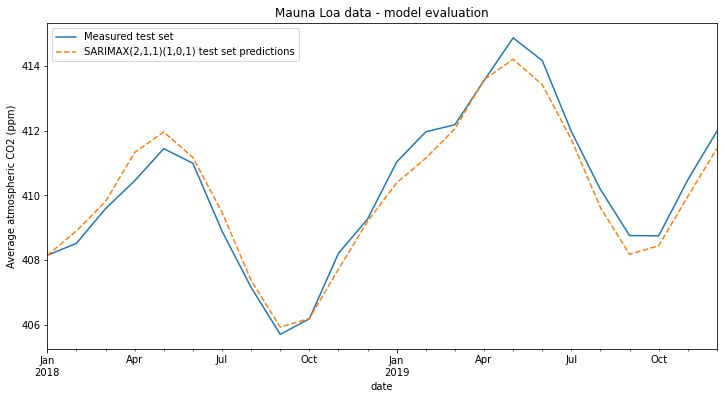

In [12]:
# Comparing SARIMAX predictions to the
# pre-pandemic test data.
ax = pre_dates_test.plot(legend = True, figsize = (12,6))
X_testpred.plot(legend = True, ls = "--")
plt.legend(['Measured test set','SARIMAX(2,1,1)(1,0,1) test set predictions'])
ax.set_ylabel(ylabel = 'Average atmospheric CO2 (ppm)')
ax.set_title(label = 'Mauna Loa data - model evaluation')

In [13]:
test_mean = pre_dates_test.mean()
test_rmse = rmse(x1 = pre_dates_test, x2 = X_testpred)
print("Mean of test data = {}\nRMSE of test data and predictions = {}\nRMSE as a percentage of the mean = {}%".format(test_mean,test_rmse,(100.0*test_rmse/(test_mean))))

Mean of test data = 410.18458333333325
RMSE of test data and predictions = 0.4730303041924405
RMSE as a percentage of the mean = 0.11532132688859156%


Since the RMSE of the SARIMAX predictions is significantly less than the mean, we can be confident that this is a solid prediction.

### Forecasting with SARIMA
Now, I will retrain the model on the entire dataset of pre-pandemic dates, and compare to the measured results.

In [14]:
# Running SARIMAX(2,1,1)(1,0,1) with seasonality of 12 months/1 year.
model = SARIMAX(endog = pre_dates['average'], order = (2,1,1), seasonal_order = (1,0,1,12))
results = model.fit()

In [15]:
# Forecasting into pandemic dates.
start = len(pre_dates)
stop = len(df) - 1
X_pred = results.predict(start = start, end = stop, dynamic = False, typ = 'levels')

Text(0.5, 1.0, 'Mauna Loa data - forecast evaluation')

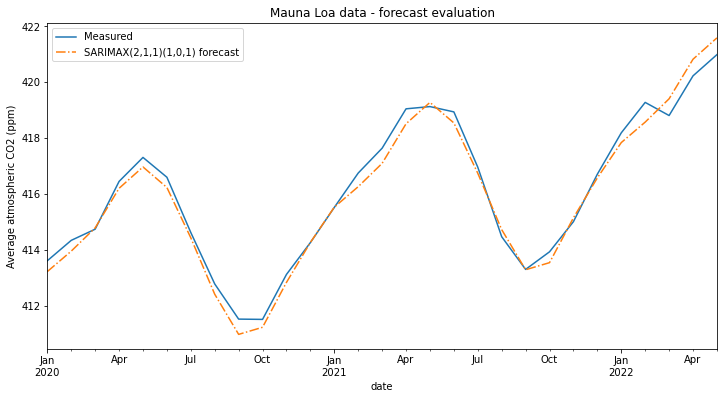

In [16]:
# Comparing SARIMAX forecast to the
# pandemic data.
ax = dates['average'].plot(legend = True, figsize = (12,6))
X_pred.plot(legend = True, ls = "-.")
plt.legend(['Measured','SARIMAX(2,1,1)(1,0,1) forecast'])
ax.set_ylabel(ylabel = 'Average atmospheric CO2 (ppm)')
ax.set_title(label = 'Mauna Loa data - forecast evaluation')

In [17]:
# Can use seasonal decomposition to find
# the trend and seasonality.
pred_res = seasonal_decompose(x = X_pred, model = 'add')
act_res = seasonal_decompose(x = dates['average'], model = 'add')

Text(0.5, 1.0, 'Mauna Loa data - forecast evaluation')

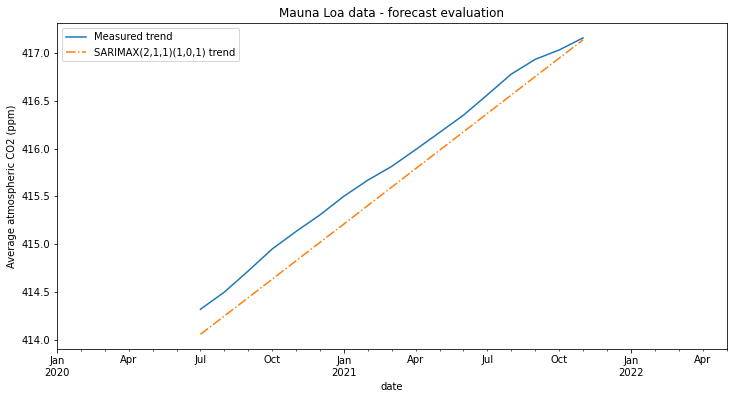

In [18]:
# Plotting the trend component.
ax = act_res.trend.plot(figsize = (12,6), legend = True)
pred_res.trend.plot(legend = True, ls = "-.")
plt.legend(['Measured trend','SARIMAX(2,1,1)(1,0,1) trend'])
ax.set_ylabel(ylabel = 'Average atmospheric CO2 (ppm)')
ax.set_title(label = 'Mauna Loa data - forecast evaluation')

Mean measured trend gradient = 0.17747395833332646 ppm per month,
Mean predicted trend gradient = 0.19264554726446192 ppm per month


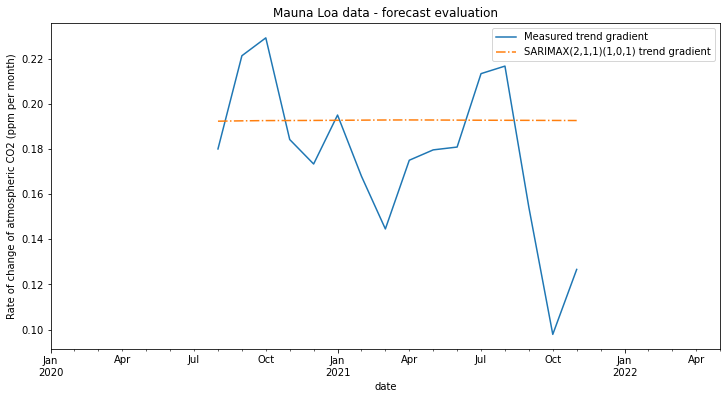

In [19]:
# Plotting the trend gradients.
ax = act_res.trend.diff().plot(figsize = (12,6), legend = True)
pred_res.trend.diff().plot(legend = True, ls = "-.")
plt.legend(['Measured trend gradient','SARIMAX(2,1,1)(1,0,1) trend gradient'])
ax.set_ylabel(ylabel = 'Rate of change of atmospheric CO2 (ppm per month)')
ax.set_title(label = 'Mauna Loa data - forecast evaluation')
print("Mean measured trend gradient = {} ppm per month,\nMean predicted trend gradient = {} ppm per month".format(act_res.trend.diff().mean(),pred_res.trend.diff().mean()))

Text(0.5, 1.0, 'Mauna Loa data - forecast evaluation')

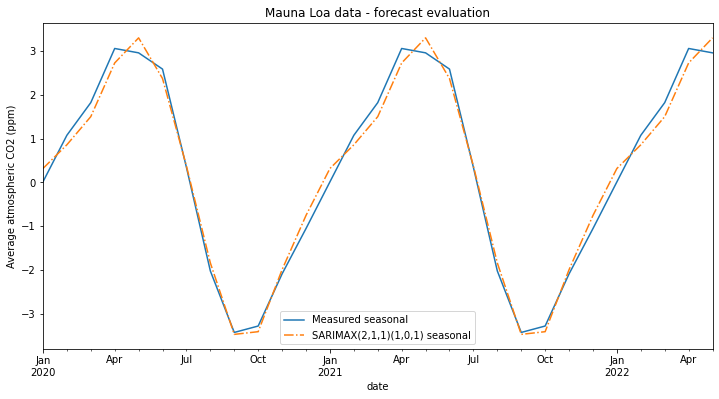

In [20]:
# Now looking at the seasonal component.
ax = act_res.seasonal.plot(figsize = (12,6), legend = True)
pred_res.seasonal.plot(legend = True, ls = "-.")
plt.legend(['Measured seasonal','SARIMAX(2,1,1)(1,0,1) seasonal'])
ax.set_ylabel(ylabel = 'Average atmospheric CO2 (ppm)')
ax.set_title(label = 'Mauna Loa data - forecast evaluation')

The Mauna Loa data does not indicate a significant change from the forecast to the measured pandemic data. Let us look at the global average data to see if there is more of a distinction.


## 2) ESRL data
I will now perform almost an identical analysis of the data, only this time using the global monthly average dataset. Since these datasets come from the same source, they are very similar in headings, so almost the exact same procedure can be used.

In [21]:
# Reading in the ESRL dataset.
df = pd.read_csv("co2_mm_gl.csv")
df.head()

,year,month,decimal,average,trend
0,1980,1,1980.042,338.55,337.93
1,1980,2,1980.125,339.27,338.22
2,1980,3,1980.208,339.60,338.25
3,1980,4,1980.292,339.99,338.37
4,1980,5,1980.375,340.43,338.91


In [22]:
# Dataframe has years and months as separate columns,
# so we can transform them into a datetime object and
# use it for the index. We will use the month start (MS)
# frequency type.
df['date'] = pd.to_datetime(arg = {'year':df['year'],'month':df['month'],'day':1})
print(df.head())
print('\n')
print(df.info())

   year  month   decimal  average   trend       date
0  1980      1  1980.042   338.55  337.93 1980-01-01
1  1980      2  1980.125   339.27  338.22 1980-02-01
2  1980      3  1980.208   339.60  338.25 1980-03-01
3  1980      4  1980.292   339.99  338.37 1980-04-01
4  1980      5  1980.375   340.43  338.91 1980-05-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     507 non-null    int64         
 1   month    507 non-null    int64         
 2   decimal  507 non-null    float64       
 3   average  507 non-null    float64       
 4   trend    507 non-null    float64       
 5   date     507 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 23.9 KB
None


In [23]:
# Counting all the na values
# for the average monthly emissions column.
sum(df['average'].isna())
# If n_null = 0 we can proceed with the analysis.

0

In [24]:
# Now we set the index as the date column.
# MS stands for month start.
df.set_index(keys = ['date'], drop = True, inplace = True)
df.index.freq = 'MS'
df.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', name='date', length=507, freq='MS')

Text(0, 0.5, 'Average atmospheric CO2 (ppm)')

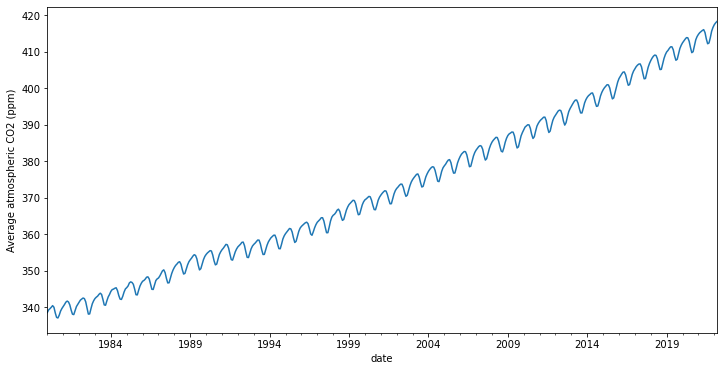

In [25]:
# Plotting the data shows seasonality and an upwards trend.
ax = df['average'].plot(figsize = (12,6))
ax.set_ylabel(ylabel = 'Average atmospheric CO2 (ppm)')

### SARIMAX grid search

In [26]:
# I am considering all dates prior to 2020
# as the pre-pandemic era, and dates post
# 2020 as the pandemic era. Today's date is
# 2022-06-09.
# Whilst the first detected case was in 2019,
# the WHO declared COVID-19 as a
# Public Health Emergency of International
# Concern on 2020-01-30, so starting at
# 2020 is a reasonable split.
pre_dates = df[df['year'] < 2020]
dates = df[df['year'] >= 2020]
print(pre_dates.info())
print('\n')
print(dates.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 1980-01-01 to 2019-12-01
Freq: MS
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     480 non-null    int64  
 1   month    480 non-null    int64  
 2   decimal  480 non-null    float64
 3   average  480 non-null    float64
 4   trend    480 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 22.5 KB
None


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27 entries, 2020-01-01 to 2022-03-01
Freq: MS
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     27 non-null     int64  
 1   month    27 non-null     int64  
 2   decimal  27 non-null     float64
 3   average  27 non-null     float64
 4   trend    27 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 1.3 KB
None


In [27]:
# Using auto_arima grid search to find
# optimal fitting parameters for the
# train data.
auto_arima_df = auto_arima(y = pre_dates['average'],
                           seasonal = True,
                           m = 12,
                           start_p = 0,
                           start_q = 0,
                           start_P = 0,
                           start_Q = 0)
auto_arima_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  480
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 329.339
Date:                            Thu, 23 Jun 2022   AIC                           -650.679
Time:                                    15:52:51   BIC                           -633.992
Sample:                                         0   HQIC                          -644.119
                                            - 480                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8229      0.025     32.354      0.000       0.773       0.873
ar.S.L12       0.9996      0.000   3578.097      0.000       0.999       1.000
ma.S.L12      -0.8667      0.029    -29.437      0.000      -0.924      -0.809
sigma2         0.0132      0.001     15.916      0.000       0.012       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.53
Prob(Q):                              0.87   Prob(JB):                         0.28
Heteroskedasticity (H):               0.59   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Train test split on pre-pandemic data

In [28]:
# Use the last two years as test data.
pre_dates_train = pre_dates.iloc[:-24]['average']
pre_dates_test = pre_dates.iloc[-24:]['average']

In [29]:
# Running SARIMAX(0,1,1)(1,0,1) with seasonality of 12 months/1 year.
model_test = SARIMAX(endog = pre_dates_train, order = (0,1,1), seasonal_order = (1,0,1,12))
test_results = model_test.fit()

In [30]:
# Generating predictions.
start = len(pre_dates_train)
stop = len(pre_dates) - 1
X_testpred = test_results.predict(start = start, end = stop, dynamic = False, typ = 'levels')

Text(0.5, 1.0, 'ESRL data - model evaluation')

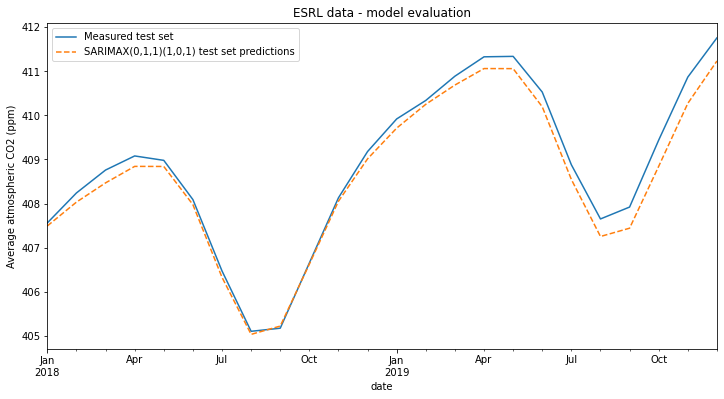

In [31]:
# Comparing SARIMAX predictions to the
# pre-pandemic test data.
ax = pre_dates_test.plot(legend = True, figsize = (12,6))
X_testpred.plot(legend = True, ls = "--")
plt.legend(['Measured test set','SARIMAX(0,1,1)(1,0,1) test set predictions'])
ax.set_ylabel(ylabel = 'Average atmospheric CO2 (ppm)')
ax.set_title(label = 'ESRL data - model evaluation')

In [32]:
test_mean = pre_dates_test.mean()
test_rmse = rmse(x1 = pre_dates_test, x2 = X_testpred)
print("Mean of test data = {}\nRMSE of test data and predictions = {}\nRMSE as a percentage of the mean = {}%".format(test_mean,test_rmse,(100.0*test_rmse/(test_mean))))

Mean of test data = 408.8450000000001
RMSE of test data and predictions = 0.2972602860037965
RMSE as a percentage of the mean = 0.07270733065190878%


### Forecasting with SARIMA

In [33]:
# Running SARIMAX(0,1,1)(1,0,1) with seasonality of 12 months/1 year.
model = SARIMAX(endog = pre_dates['average'], order = (0,1,1), seasonal_order = (1,0,1,12))
results = model.fit()

In [34]:
# Forecasting into pandemic dates.
start = len(pre_dates)
stop = len(df) - 1
X_pred = results.predict(start = start, end = stop, dynamic = False, typ = 'levels')

Text(0.5, 1.0, 'ESRL data - forecast evaluation')

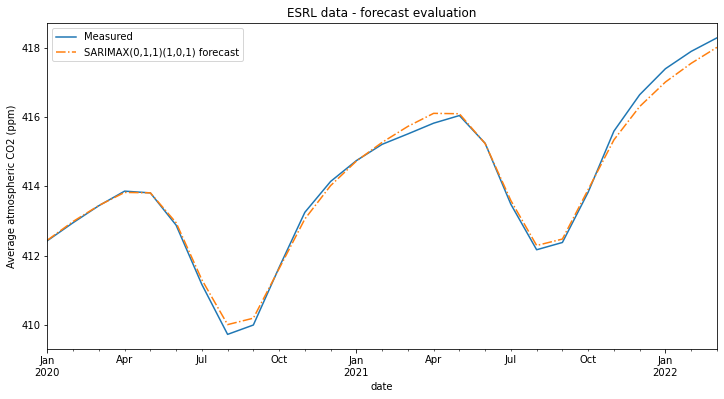

In [35]:
# Comparing SARIMAX forecast to the
# pandemic data.
ax = dates['average'].plot(legend = True, figsize = (12,6))
X_pred.plot(legend = True, ls = "-.")
plt.legend(['Measured','SARIMAX(0,1,1)(1,0,1) forecast'])
ax.set_ylabel(ylabel = 'Average atmospheric CO2 (ppm)')
ax.set_title(label = 'ESRL data - forecast evaluation')

In [36]:
# Can use seasonal decomposition to find
# the trend and seasonality.
pred_res = seasonal_decompose(x = X_pred, model = 'add')
act_res = seasonal_decompose(x = dates['average'], model = 'add')

Text(0.5, 1.0, 'ESRL data - forecast evaluation')

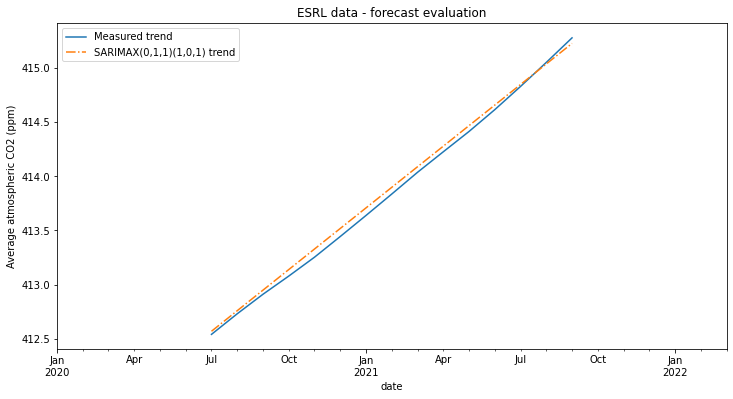

In [37]:
# Plotting the trend component.
ax = act_res.trend.plot(figsize = (12,6), legend = True)
pred_res.trend.plot(legend = True, ls = "-.")
plt.legend(['Measured trend','SARIMAX(0,1,1)(1,0,1) trend'])
ax.set_ylabel(ylabel = 'Average atmospheric CO2 (ppm)')
ax.set_title(label = 'ESRL data - forecast evaluation')

Mean measured trend gradient = 0.19577380952381013 ppm per month,
Mean predicted trend gradient = 0.19005209810859874 ppm per month


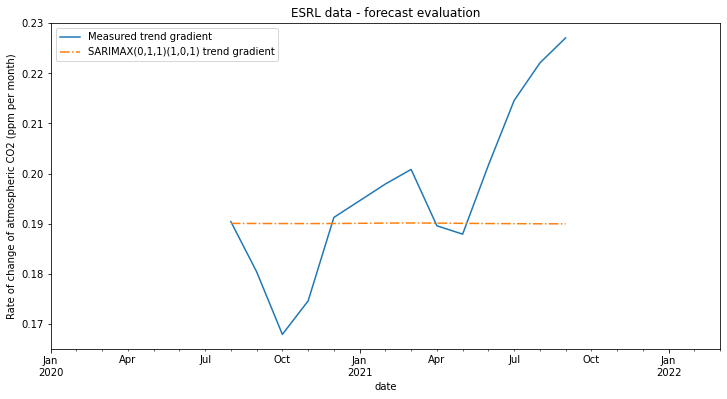

In [38]:
# Plotting the trend gradients.
ax = act_res.trend.diff().plot(figsize = (12,6), legend = True)
pred_res.trend.diff().plot(legend = True, ls = "-.")
plt.legend(['Measured trend gradient','SARIMAX(0,1,1)(1,0,1) trend gradient'])
ax.set_ylabel(ylabel = 'Rate of change of atmospheric CO2 (ppm per month)')
ax.set_title(label = 'ESRL data - forecast evaluation')
print("Mean measured trend gradient = {} ppm per month,\nMean predicted trend gradient = {} ppm per month".format(act_res.trend.diff().mean(),pred_res.trend.diff().mean()))

Text(0.5, 1.0, 'ESRL data - forecast evaluation')

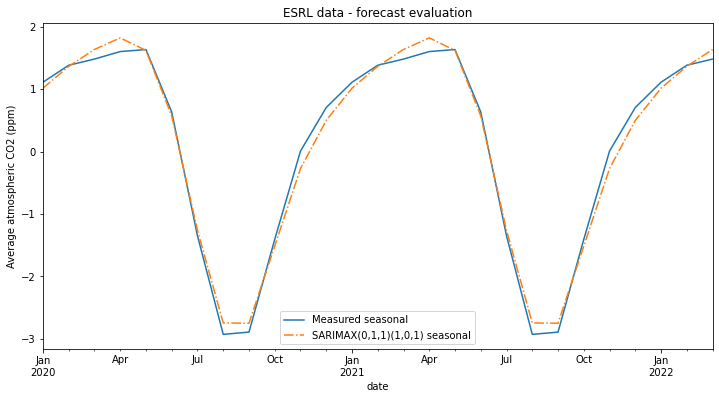

In [39]:
# Now looking at the seasonal component.
ax = act_res.seasonal.plot(figsize = (12,6), legend = True)
pred_res.seasonal.plot(legend = True, ls = "-.")
plt.legend(['Measured seasonal','SARIMAX(0,1,1)(1,0,1) seasonal'])
ax.set_ylabel(ylabel = 'Average atmospheric CO2 (ppm)')
ax.set_title(label = 'ESRL data - forecast evaluation')

## Conclusion
The measured and predicted/forecasted atmospheric $\text{CO}_{2}$ levels from both datasets were very similar. This means that the expected decrease in growth of atmospheric $\text{CO}_{2}$ due to less worker commuting did not offset other facets of atmospheric $\text{CO}_{2}$ production.

We expected that the growth/gradient of the trend component of the atmospheric $\text{CO}_{2}$ levels to decrease with the pandemic, with our most extreme expected result being that the gradient of the trend going to zero. Looking at the decomposed trend, the gradient of the trend is very similar for all dates. Looking specifically at the trend gradient, we see some slight variations. Closer to the end dates, the measured trend gradient of the Mauna Loa data starts to decrease slightly relative to the forecast, but the measured trend features a slightly higher background level across the dates. For the ERSL data, the measured trend gradient actually increases relative to the forecast in the later dates. For both datasets, the measured and forecasted seasonal components are very similar as expected, since the seasonal component is mainly from plants responding to the variations of ecological factors from different seasons (https://gml.noaa.gov/ccgg/covid2.html) and not from commuter habits.

Due to the similarities in the trend gradients, this global event did not reflect a significant change in the atmospheric $\text{CO}_{2}$ levels. This is corroborated by the owners of the data set, who performed a different analysis of the data and came to the same conclusion, as well as other independent authors of publication https://www.pnas.org/doi/10.1073/pnas.2109481118. Publication https://www.pnas.org/doi/10.1073/pnas.2109481118 reports that whilst emissions did decrease in March 2020 (when COVID-19 was declared a pandemic), that emission decrease was almost completely reverted by the backend of the year 2020. This could be due to increased reliance on goods delivery services during the pandemic, which can offset the reduction of emissions due to less commuting. Combined with this emission recovery, the authors also found that the ocean storage of $\text{CO}_{2}$ was reduced in 2020, and there was large interannual variability in $\text{CO}_{2}$ uptake and release from land sources, which contributes overall to a lack of changes in atmospheric $\text{CO}_{2}$ levels. 

Publication https://www.pnas.org/doi/10.1073/pnas.2109481118 has data to the start of 2021 only, but even with the new data considered in this notebook the story is the same - the massive shift of commuter behaviour in the pandemic did not move the needle enough. Drastic changes will be needed to reduce the trend gradient to zero, and then even more changes will be needed to reduce the atmospheric $\text{CO}_{2}$ levels to a manageable level for all living things for generations to come.